## Total Cost Model Building and Exploration 

This notebook shows the process of building classification models for Total Costs. It shows the performance of models with different bin sizes, different models, and upsampling techniques. This notebook also contains an evaluation of model performance across sub-populations.

In [ ]:
!pip install imbalanced-learn

First, we will be importing all necessary libraries required for our Random Forest classification, and we will looking at various metrics including the accuracy, precision, and recall.

In [1]:
#Import all needed models
import sys
sys.path.insert(0, '../src/helpers')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomFoHistGradientBoostingClassifier
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss, f1_score, classification_report, make_scorer, precision_score, recall_score, accuracy_score, confusion_matrix, plot_confusion_matrix
import seaborn as sns
import imblearn
# print(imblearn.__version__)

The below two cells can be run if the *processed data is not present*, as the below will take the raw data, clean and get it ready for processing.

In [ ]:
from data_ingestion import *

In [ ]:
from data_processing import *

The below two cells must be run at all times in order to bring in the helper functions for the models and additonally clean data further for data modeling.

In [2]:
from data_cleaners import *
from model_building_helpers import *

In [3]:
#Load all patient csv (csv containing data for all the indications (COPD, Heart Failure, Schizophrenia, Knee Replacement, Kidney/UTI))
all_patient_df = load_data('All')

All


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


       Hospital Service Area Hospital County  Permanent Facility Id  \
0              Hudson Valley     Westchester                 1061.0   
1              Hudson Valley     Westchester                 1061.0   
2              Hudson Valley     Westchester                 1072.0   
3              Hudson Valley        Sullivan                  971.0   
4              Hudson Valley        Sullivan                  971.0   
...                      ...             ...                    ...   
420987         New York City          Queens                 1629.0   
420988         New York City          Queens                 1629.0   
420989          Finger Lakes         Ontario                  676.0   
420990         New York City           Bronx                 3058.0   
420991         New York City           Bronx                 1169.0   

          Age Group  Gender                    Race          Ethnicity  \
0          30 to 49    Male                   White  Not Span/Hispanic   

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


###### Step 1 - Creating Bins for Total Cost

We will first create different bins for our classifier.

In [4]:
maxcost = all_patient_df['Total Costs'].max()
print("Maximum Total Cost:", maxcost)

#Bin the data by length of stay ranges
bins = [1, 5000, 10000, 15000, 20000, 30000, 50000, 1250000]
labels = ['1 - 5000', '5001 - 10000', '10001 - 15000', '15001 - 20000'
          , '20001 - 30000', '30001 - 50000', '50001 - 1250000']

all_patient_df_bins = all_patient_df.copy()
all_patient_df_bins['Total Costs Bin'] = pd.cut(x = all_patient_df_bins['Total Costs'], 
                                                bins = bins, labels = labels, include_lowest = True)
all_patient_df_bins.head(10)

Maximum Total Cost: 1159410


,Hospital Service Area,Hospital County,Permanent Facility Id,Age Group,Gender,Race,Ethnicity,Type of Admission,Patient Disposition,CCSR Diagnosis Code,...,APR Severity of Illness Code,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Emergency Department Indicator,Total Costs,Total Charges,Length of Stay,Total Costs Bin
0,Hudson Valley,Westchester,1061,3,Male,White,Not Span/Hispanic,Elective,Home or Self Care,659,...,2,Moderate,1,Medical,Medicare,0,40464,114168,21,30001 - 50000
1,Hudson Valley,Westchester,1061,4,Male,White,Spanish/Hispanic,Emergency,Skilled Nursing Home,99,...,3,Major,2,Medical,Medicaid,0,26046,58517,8,20001 - 30000
2,Hudson Valley,Westchester,1072,5,Male,Black/African American,Not Span/Hispanic,Emergency,Skilled Nursing Home,108,...,2,Moderate,3,Medical,Medicare,0,13980,26213,4,10001 - 15000
3,Hudson Valley,Sullivan,971,3,Female,White,Not Span/Hispanic,Emergency,Home or Self Care,659,...,2,Moderate,2,Medical,Private Health Insurance,1,17794,39854,20,15001 - 20000
4,Hudson Valley,Sullivan,971,4,Female,White,Not Span/Hispanic,Emergency,Skilled Nursing Home,108,...,3,Major,3,Medical,Medicare,1,21015,69112,12,20001 - 30000
5,Hudson Valley,Sullivan,971,2,Male,Black/African American,Not Span/Hispanic,Emergency,Home or Self Care,659,...,2,Moderate,1,Medical,Private Health Insurance,1,8232,18602,11,5001 - 10000
6,Hudson Valley,Sullivan,971,3,Male,Black/African American,Not Span/Hispanic,Emergency,Another Type Not Listed,659,...,2,Moderate,1,Medical,Private Health Insurance,1,5528,12169,6,5001 - 10000
7,Hudson Valley,Sullivan,971,5,Female,White,Not Span/Hispanic,Emergency,Skilled Nursing Home,159,...,3,Major,3,Medical,Medicare,1,11323,39420,7,10001 - 15000
8,Hudson Valley,Sullivan,971,3,Male,White,Not Span/Hispanic,Emergency,Home or Self Care,659,...,2,Moderate,2,Medical,Medicare,1,8750,19670,9,5001 - 10000
9,Hudson Valley,Sullivan,971,4,Female,White,Not Span/Hispanic,Emergency,Skilled Nursing Home,159,...,3,Major,3,Medical,Medicare,1,12787,40184,8,10001 - 15000


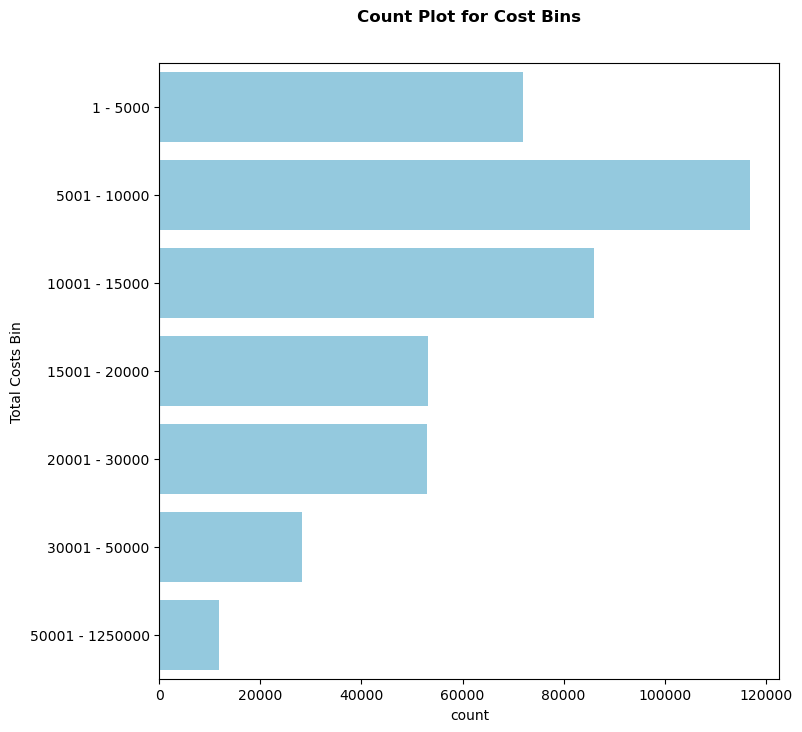

In [77]:
plt.figure(figsize = (8, 8))
plt.title('Count Plot for Cost Bins', fontsize=12, weight='bold', pad=30)
sns.countplot(data=all_patient_df_bins, y="Total Costs Bin", palette=['skyblue'])
plt.savefig('data/visualizations/CostBins_CountPlot.png')

###### Step 2 - Train model on Hist Gradient Boosting Classfier
This will help us with understanding the Accuracy and F1-scores of the model

In [8]:
X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(all_patient_df_bins)

model = HistGradientBoostingClassifier()
model.fit(X_train, np.ravel(y_train))
y_pred = model.predict(X_test)
bin1_accuracy = accuracy_score(y_test, y_pred)
bin1_f1_score_macro = f1_score(y_test, y_pred, average='macro')
bin1_f1_score_weighted = f1_score(y_test, y_pred, average='weighted')
cf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy = ", bin1_accuracy, "\nF1 Macro Score = ", bin1_f1_score_macro, "\nF1 Weighted Score = ", bin1_f1_score_weighted)

Accuracy =  0.43809433319873 
F1 Macro Score =  0.37133198528083194 
F1 Weighted Score =  0.418371239725186


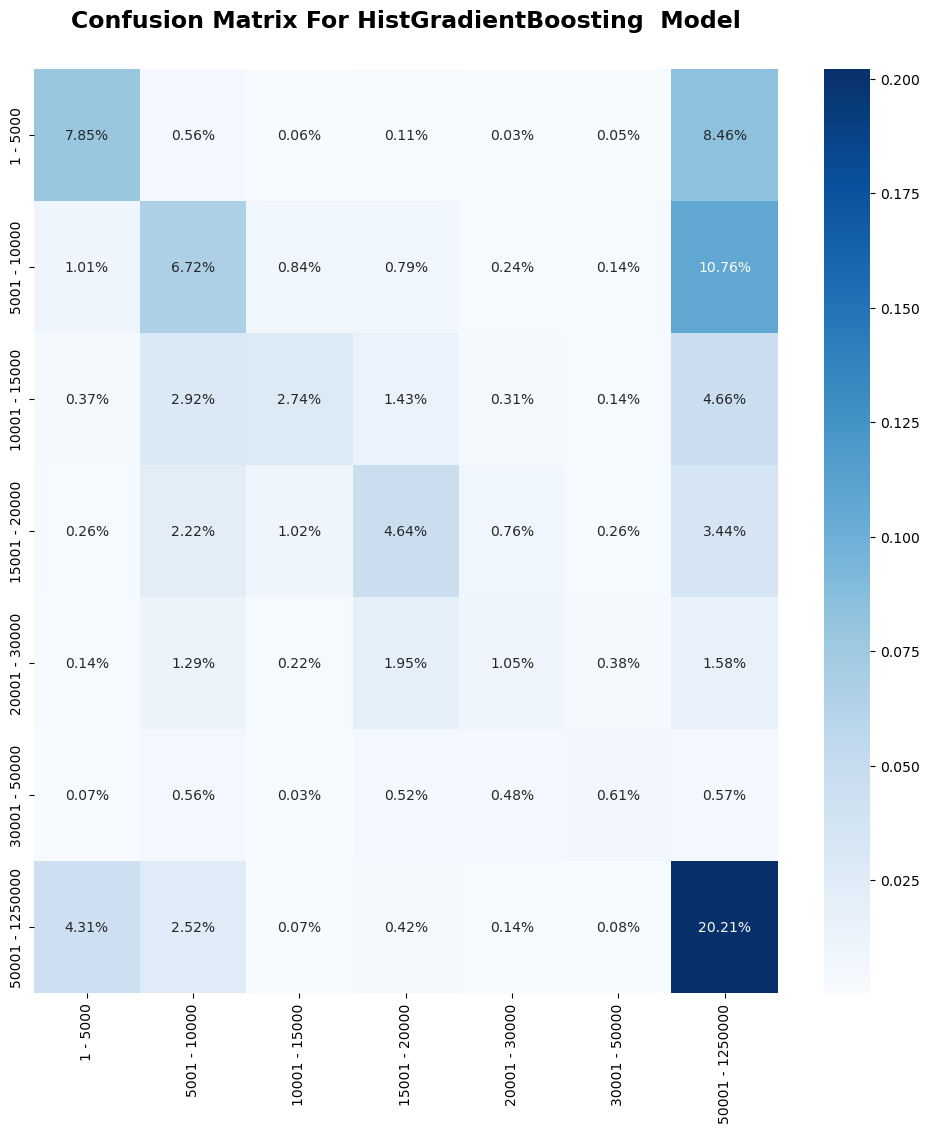

In [76]:
#Visualize the confusion matrix as a heart map
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (12, 12))
plt.title('Confusion Matrix For HistGradientBoosting  Model', fontsize=17, weight='bold', pad=30)
sns.heatmap(df_cm, annot=True, fmt='.2%',  cmap='Blues')
plt.savefig('data/visualizations/Cost_ConfusionMatrix.png')

In [10]:
#Get Gradient Boost Classifier best parameters and best score by sub-population
#Experiment model performance by changing the parameters tested and interations for the RandomizedSearch
gb_scores = []
iterations = 10 #We found the iterations did not affect F1 macro scores much, so we used the default of 10

for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    subpop_df = load_data(drg)
    subpop_df['Total Costs Bin'] = pd.cut(x = subpop_df['Total Costs'], bins = bins, labels = labels, 
                                          include_lowest = True)
    if len(subpop_df) > 30000:
        subpop_df = subpop_df.groupby('Total Costs Bin', group_keys=False).apply(
            lambda x: x.sample(int(np.rint(30000*len(x)/len(subpop_df))))).sample(frac=1).reset_index(drop=True)
        
    X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(subpop_df)

    random_grid = {'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                   'learning_rate': [0.1 , 0.5 , 1],
                   'min_samples_leaf': [1, 2, 4],
                   'loss': ['log_loss', 'auto', 'binary_crossentropy','categorical_crossentropy']}
    
    best_params, best_score = get_best_gbc_params(X_train, y_train, random_grid, iterations)
    gb_scores.append({drg:{
            'best_params': best_params,
            'best_score': best_score
            }
        }
    )

all


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


       Hospital Service Area Hospital County  Permanent Facility Id  \
0              Hudson Valley     Westchester                 1061.0   
1              Hudson Valley     Westchester                 1061.0   
2              Hudson Valley     Westchester                 1072.0   
3              Hudson Valley        Sullivan                  971.0   
4              Hudson Valley        Sullivan                  971.0   
...                      ...             ...                    ...   
420987         New York City          Queens                 1629.0   
420988         New York City          Queens                 1629.0   
420989          Finger Lakes         Ontario                  676.0   
420990         New York City           Bronx                 3058.0   
420991         New York City           Bronx                 1169.0   

          Age Group  Gender                    Race          Ethnicity  \
0          30 to 49    Male                   White  Not Span/Hispanic   

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: Fut

{'min_samples_leaf': 4, 'max_depth': 30, 'loss': 'log_loss', 'learning_rate': 0.1} 0.3348597529396897
194.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:8: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_HeartFailure.csv')


       Hospital Service Area Hospital County  Permanent Facility Id  \
0              Hudson Valley     Westchester                 1061.0   
1              Hudson Valley     Westchester                 1072.0   
2              Hudson Valley        Sullivan                  971.0   
3              Hudson Valley        Sullivan                  971.0   
4              Hudson Valley        Sullivan                  971.0   
...                      ...             ...                    ...   
126582                   NaN             NaN                10216.0   
126583                   NaN             NaN                10216.0   
126584         New York City           Bronx                 1169.0   
126585         New York City          Queens                 1629.0   
126586         New York City           Bronx                 3058.0   

          Age Group  Gender                    Race          Ethnicity  \
0          50 to 69    Male                   White   Spanish/Hispanic   

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:8: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_HeartFailure.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'binary_c

{'min_samples_leaf': 4, 'max_depth': 100, 'loss': 'log_loss', 'learning_rate': 0.1} 0.24736098527538739
140.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:11: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_ChronicObstructivePulmonaryDisease.csv')


      Hospital Service Area Hospital County  Permanent Facility Id  \
0             New York City           Kings                 1324.0   
1             New York City           Kings                 1324.0   
2             New York City       Manhattan                 1439.0   
3             New York City       Manhattan                 1456.0   
4             New York City       Manhattan                 1456.0   
...                     ...             ...                    ...   
80018                   NaN             NaN                10216.0   
80019                   NaN             NaN                10216.0   
80020       Capital/Adirond         Clinton                  135.0   
80021         New York City          Queens                 1629.0   
80022         New York City           Bronx                 1169.0   

         Age Group  Gender                    Race          Ethnicity  \
0         50 to 69    Male                   White  Not Span/Hispanic   
1      70 or 

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:11: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_ChronicObstructivePulmonaryDisease.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'binary_crossentropy' was deprecated in

{'min_samples_leaf': 4, 'max_depth': 110, 'loss': 'auto', 'learning_rate': 0.5} 0.23817899592539105
750.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:14: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_Schizophrenia.csv')


      Hospital Service Area Hospital County  Permanent Facility Id Age Group  \
0             Hudson Valley     Westchester                 1061.0  30 to 49   
1             Hudson Valley        Sullivan                  971.0  30 to 49   
2             Hudson Valley        Sullivan                  971.0  18 to 29   
3             Hudson Valley        Sullivan                  971.0  30 to 49   
4             Hudson Valley        Sullivan                  971.0  30 to 49   
...                     ...             ...                    ...       ...   
70869         New York City          Queens                 1629.0  18 to 29   
70870         New York City          Queens                 1629.0  30 to 49   
70871         New York City       Manhattan                 1466.0  18 to 29   
70872         New York City          Queens                 1630.0  18 to 29   
70873         New York City          Queens                 1629.0  50 to 69   

       Gender                    Race  

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:14: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_Schizophrenia.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'binary_crossentropy' was deprecated in

{'min_samples_leaf': 2, 'max_depth': 100, 'loss': 'log_loss', 'learning_rate': 0.1} 0.23708518236919407
463.0
      Hospital Service Area Hospital County  Permanent Facility Id  \
0             Hudson Valley        Sullivan                  971.0   
1             Hudson Valley        Sullivan                  971.0   
2             New York City           Kings                 1324.0   
3             New York City           Kings                 1324.0   
4             New York City       Manhattan                 1439.0   
...                     ...             ...                    ...   
60964         New York City           Kings                 1301.0   
60965         New York City           Kings                 1294.0   
60966         New York City           Kings                 1294.0   
60967         New York City          Queens                 1629.0   
60968          Finger Lakes         Ontario                  676.0   

         Age Group  Gender                    Rac

/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss

{'min_samples_leaf': 2, 'max_depth': 110, 'loss': 'categorical_crossentropy', 'learning_rate': 0.1} 0.2354407985488516
302.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:20: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_KneeJointReplacement.csv')


      Hospital Service Area Hospital County  Permanent Facility Id  \
0             New York City       Manhattan                 1456.0   
1             New York City       Manhattan                 1456.0   
2             New York City       Manhattan                 1466.0   
3             New York City       Manhattan                 1466.0   
4             New York City       Manhattan                 1466.0   
...                     ...             ...                    ...   
82534       Capital/Adirond         Clinton                  135.0   
82535       Capital/Adirond         Clinton                  135.0   
82536       Capital/Adirond         Clinton                  135.0   
82537       Capital/Adirond         Clinton                  135.0   
82538         New York City           Bronx                 1168.0   

         Age Group  Gender                    Race          Ethnicity  \
0         50 to 69  Female              Other Race  Not Span/Hispanic   
1      70 or 

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:20: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_KneeJointReplacement.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning

{'min_samples_leaf': 4, 'max_depth': 50, 'loss': 'log_loss', 'learning_rate': 0.1} 0.4606919340630116


In [11]:
#Get LogisticRegression best parameters and best score by sub-population
#Experiment model performance by changing the parameters tested and interations for the RandomizedSearch
lr_scores = []
iterations = 10 #We found the iterations did not affect F1 macro scores much, so we used the default of 10

for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    subpop_df = load_data(drg)
    subpop_df['Total Costs Bin'] = pd.cut(x = subpop_df['Total Costs'], bins = bins, 
                                          labels = labels, include_lowest = True)
    if len(subpop_df) > 30000:
        subpop_df = subpop_df.groupby('Total Costs Bin', group_keys=False).apply(
            lambda x: x.sample(int(np.rint(30000*len(x)/len(subpop_df)
                                          )
                                  )
                              )).sample(frac=1).reset_index(drop=True)
        
    X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(subpop_df)

    random_grid = {'C' : np.logspace(0, 4, num=10),
    'penalty' : ['l1', 'l2'],
    'solver' : ['liblinear'],
    'class_weight': ['balanced', None]}
    
    best_params, best_score = get_best_lr_params(X_train, y_train, random_grid, iterations)
    lr_scores.append({drg:{
            'best_params': best_params,
            'best_score': best_score
            }
        }
    )

all


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


       Hospital Service Area Hospital County  Permanent Facility Id  \
0              Hudson Valley     Westchester                 1061.0   
1              Hudson Valley     Westchester                 1061.0   
2              Hudson Valley     Westchester                 1072.0   
3              Hudson Valley        Sullivan                  971.0   
4              Hudson Valley        Sullivan                  971.0   
...                      ...             ...                    ...   
420987         New York City          Queens                 1629.0   
420988         New York City          Queens                 1629.0   
420989          Finger Lakes         Ontario                  676.0   
420990         New York City           Bronx                 3058.0   
420991         New York City           Bronx                 1169.0   

          Age Group  Gender                    Race          Ethnicity  \
0          30 to 49    Male                   White  Not Span/Hispanic   

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 

194.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:8: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_HeartFailure.csv')


       Hospital Service Area Hospital County  Permanent Facility Id  \
0              Hudson Valley     Westchester                 1061.0   
1              Hudson Valley     Westchester                 1072.0   
2              Hudson Valley        Sullivan                  971.0   
3              Hudson Valley        Sullivan                  971.0   
4              Hudson Valley        Sullivan                  971.0   
...                      ...             ...                    ...   
126582                   NaN             NaN                10216.0   
126583                   NaN             NaN                10216.0   
126584         New York City           Bronx                 1169.0   
126585         New York City          Queens                 1629.0   
126586         New York City           Bronx                 3058.0   

          Age Group  Gender                    Race          Ethnicity  \
0          50 to 69    Male                   White   Spanish/Hispanic   

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:8: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_HeartFailure.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 

140.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:11: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_ChronicObstructivePulmonaryDisease.csv')


      Hospital Service Area Hospital County  Permanent Facility Id  \
0             New York City           Kings                 1324.0   
1             New York City           Kings                 1324.0   
2             New York City       Manhattan                 1439.0   
3             New York City       Manhattan                 1456.0   
4             New York City       Manhattan                 1456.0   
...                     ...             ...                    ...   
80018                   NaN             NaN                10216.0   
80019                   NaN             NaN                10216.0   
80020       Capital/Adirond         Clinton                  135.0   
80021         New York City          Queens                 1629.0   
80022         New York City           Bronx                 1169.0   

         Age Group  Gender                    Race          Ethnicity  \
0         50 to 69    Male                   White  Not Span/Hispanic   
1      70 or 

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:11: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_ChronicObstructivePulmonaryDisease.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 

750.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:14: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_Schizophrenia.csv')


      Hospital Service Area Hospital County  Permanent Facility Id Age Group  \
0             Hudson Valley     Westchester                 1061.0  30 to 49   
1             Hudson Valley        Sullivan                  971.0  30 to 49   
2             Hudson Valley        Sullivan                  971.0  18 to 29   
3             Hudson Valley        Sullivan                  971.0  30 to 49   
4             Hudson Valley        Sullivan                  971.0  30 to 49   
...                     ...             ...                    ...       ...   
70869         New York City          Queens                 1629.0  18 to 29   
70870         New York City          Queens                 1629.0  30 to 49   
70871         New York City       Manhattan                 1466.0  18 to 29   
70872         New York City          Queens                 1630.0  18 to 29   
70873         New York City          Queens                 1629.0  50 to 69   

       Gender                    Race  

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:14: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_Schizophrenia.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 

463.0
      Hospital Service Area Hospital County  Permanent Facility Id  \
0             Hudson Valley        Sullivan                  971.0   
1             Hudson Valley        Sullivan                  971.0   
2             New York City           Kings                 1324.0   
3             New York City           Kings                 1324.0   
4             New York City       Manhattan                 1439.0   
...                     ...             ...                    ...   
60964         New York City           Kings                 1301.0   
60965         New York City           Kings                 1294.0   
60966         New York City           Kings                 1294.0   
60967         New York City          Queens                 1629.0   
60968          Finger Lakes         Ontario                  676.0   

         Age Group  Gender                    Race          Ethnicity  \
0      70 or Older  Female                   White  Not Span/Hispanic   
1      

/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 

/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


302.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:20: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_KneeJointReplacement.csv')


      Hospital Service Area Hospital County  Permanent Facility Id  \
0             New York City       Manhattan                 1456.0   
1             New York City       Manhattan                 1456.0   
2             New York City       Manhattan                 1466.0   
3             New York City       Manhattan                 1466.0   
4             New York City       Manhattan                 1466.0   
...                     ...             ...                    ...   
82534       Capital/Adirond         Clinton                  135.0   
82535       Capital/Adirond         Clinton                  135.0   
82536       Capital/Adirond         Clinton                  135.0   
82537       Capital/Adirond         Clinton                  135.0   
82538         New York City           Bronx                 1168.0   

         Age Group  Gender                    Race          Ethnicity  \
0         50 to 69  Female              Other Race  Not Span/Hispanic   
1      70 or 

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:20: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_KneeJointReplacement.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 

In [12]:
#Get Random Forest best parameters and best score by sub-population
#Experiment model performance by changing the parameters tested and interations for the RandomizedSearch
rf_scores = []
iterations = 10 #We found the iterations did not affect F1 macro scores much, so we used the default of 10

for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    subpop_df = load_data(drg)
    subpop_df['Total Costs Bin'] = pd.cut(x = subpop_df['Total Costs'], bins = bins, 
                                          labels = labels, include_lowest = True)
    if len(subpop_df) > 30000:
        subpop_df = subpop_df.groupby('Total Costs Bin', group_keys=False).apply(
            lambda x: x.sample(int(np.rint(30000*len(x)/len(subpop_df)
                                          )
                                  )
                              )).sample(frac=1).reset_index(drop=True)
        
    X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(subpop_df)

    random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 800, num = 15)],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False],
               'class_weight': ['balanced', 'balanced_subsample']}
    
    best_params, best_score = get_best_rf_params(X_train, y_train, random_grid, iterations)
    
    rf_scores.append({drg:{
            'best_params': best_params,
            'best_score': best_score
            }
        }
    )

all


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


       Hospital Service Area Hospital County  Permanent Facility Id  \
0              Hudson Valley     Westchester                 1061.0   
1              Hudson Valley     Westchester                 1061.0   
2              Hudson Valley     Westchester                 1072.0   
3              Hudson Valley        Sullivan                  971.0   
4              Hudson Valley        Sullivan                  971.0   
...                      ...             ...                    ...   
420987         New York City          Queens                 1629.0   
420988         New York City          Queens                 1629.0   
420989          Finger Lakes         Ontario                  676.0   
420990         New York City           Bronx                 3058.0   
420991         New York City           Bronx                 1169.0   

          Age Group  Gender                    Race          Ethnicity  \
0          30 to 49    Male                   White  Not Span/Hispanic   

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.32255628542821424
194.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:8: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_HeartFailure.csv')


       Hospital Service Area Hospital County  Permanent Facility Id  \
0              Hudson Valley     Westchester                 1061.0   
1              Hudson Valley     Westchester                 1072.0   
2              Hudson Valley        Sullivan                  971.0   
3              Hudson Valley        Sullivan                  971.0   
4              Hudson Valley        Sullivan                  971.0   
...                      ...             ...                    ...   
126582                   NaN             NaN                10216.0   
126583                   NaN             NaN                10216.0   
126584         New York City           Bronx                 1169.0   
126585         New York City          Queens                 1629.0   
126586         New York City           Bronx                 3058.0   

          Age Group  Gender                    Race          Ethnicity  \
0          50 to 69    Male                   White   Spanish/Hispanic   

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:8: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_HeartFailure.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.2647043293120463
140.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:11: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_ChronicObstructivePulmonaryDisease.csv')


      Hospital Service Area Hospital County  Permanent Facility Id  \
0             New York City           Kings                 1324.0   
1             New York City           Kings                 1324.0   
2             New York City       Manhattan                 1439.0   
3             New York City       Manhattan                 1456.0   
4             New York City       Manhattan                 1456.0   
...                     ...             ...                    ...   
80018                   NaN             NaN                10216.0   
80019                   NaN             NaN                10216.0   
80020       Capital/Adirond         Clinton                  135.0   
80021         New York City          Queens                 1629.0   
80022         New York City           Bronx                 1169.0   

         Age Group  Gender                    Race          Ethnicity  \
0         50 to 69    Male                   White  Not Span/Hispanic   
1      70 or 

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:11: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_ChronicObstructivePulmonaryDisease.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.24405140092717184
750.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:14: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_Schizophrenia.csv')


      Hospital Service Area Hospital County  Permanent Facility Id Age Group  \
0             Hudson Valley     Westchester                 1061.0  30 to 49   
1             Hudson Valley        Sullivan                  971.0  30 to 49   
2             Hudson Valley        Sullivan                  971.0  18 to 29   
3             Hudson Valley        Sullivan                  971.0  30 to 49   
4             Hudson Valley        Sullivan                  971.0  30 to 49   
...                     ...             ...                    ...       ...   
70869         New York City          Queens                 1629.0  18 to 29   
70870         New York City          Queens                 1629.0  30 to 49   
70871         New York City       Manhattan                 1466.0  18 to 29   
70872         New York City          Queens                 1630.0  18 to 29   
70873         New York City          Queens                 1629.0  50 to 69   

       Gender                    Race  

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:14: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_Schizophrenia.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.23116984772604396
463.0
      Hospital Service Area Hospital County  Permanent Facility Id  \
0             Hudson Valley        Sullivan                  971.0   
1             Hudson Valley        Sullivan                  971.0   
2             New York City           Kings                 1324.0   
3             New York City           Kings                 1324.0   
4             New York City       Manhattan                 1439.0   
...                     ...             ...                    ...   
60964         New York City           Kings                 1301.0   
60965         New York City           Kings                 1294.0   
60966         New York City           Kings                 1294.0   
60967         New York City          Queens                 1629.0   
60968          Finger Lakes         Ontario                  676.0   

         Age Group  Gender                    Race          Ethnicity  \

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:20: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_KneeJointReplacement.csv')


      Hospital Service Area Hospital County  Permanent Facility Id  \
0             New York City       Manhattan                 1456.0   
1             New York City       Manhattan                 1456.0   
2             New York City       Manhattan                 1466.0   
3             New York City       Manhattan                 1466.0   
4             New York City       Manhattan                 1466.0   
...                     ...             ...                    ...   
82534       Capital/Adirond         Clinton                  135.0   
82535       Capital/Adirond         Clinton                  135.0   
82536       Capital/Adirond         Clinton                  135.0   
82537       Capital/Adirond         Clinton                  135.0   
82538         New York City           Bronx                 1168.0   

         Age Group  Gender                    Race          Ethnicity  \
0         50 to 69  Female              Other Race  Not Span/Hispanic   
1      70 or 

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:20: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_KneeJointReplacement.csv')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.42300511984049316


In [40]:
scores_gb_df = pd.DataFrame(columns=['model', 'subpopulation', 'best_params', 'best_scores'])
for item in gb_scores:
    for key, item in item.items():
        scores_gb_df = scores_gb_df.append({'model': 'HistGradientBoost', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
scores_gb_df.head()


/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_60026/1332079419.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_gb_df = scores_gb_df.append({'model': 'HistGradientBoost', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_60026/1332079419.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_gb_df = scores_gb_df.append({'model': 'HistGradientBoost', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_60026/1332079419.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

,model,subpopulation,best_params,best_scores
0,HistGradientBoost,all,"{'min_samples_leaf': 4, 'max_depth': 30, 'loss...",0.334860
1,HistGradientBoost,194.0,"{'min_samples_leaf': 4, 'max_depth': 100, 'los...",0.247361
2,HistGradientBoost,140.0,"{'min_samples_leaf': 4, 'max_depth': 110, 'los...",0.238179
3,HistGradientBoost,750.0,"{'min_samples_leaf': 2, 'max_depth': 100, 'los...",0.237085
4,HistGradientBoost,463.0,"{'min_samples_leaf': 2, 'max_depth': 110, 'los...",0.235441


In [41]:
scores_lr_df = pd.DataFrame(columns=['model', 'subpopulation', 'best_params', 'best_scores'])
for item in lr_scores:
    for key, item in item.items():
        scores_lr_df = scores_lr_df.append({'model': 'LogRegression', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
scores_lr_df.head()


/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_60026/2915300335.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_lr_df = scores_lr_df.append({'model': 'LogRegression', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_60026/2915300335.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_lr_df = scores_lr_df.append({'model': 'LogRegression', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_60026/2915300335.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

,model,subpopulation,best_params,best_scores
0,LogRegression,all,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.302041
1,LogRegression,194.0,"{'solver': 'liblinear', 'penalty': 'l2', 'clas...",0.253287
2,LogRegression,140.0,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.246678
3,LogRegression,750.0,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.218149
4,LogRegression,463.0,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.235078


In [42]:
scores_rf_df = pd.DataFrame(columns=['model', 'subpopulation', 'best_params', 'best_scores'])
for item in rf_scores:
    for key, item in item.items():
        scores_rf_df = scores_rf_df.append({'model': 'RandomForest', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
scores_rf_df.head()


/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_60026/2731067456.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_rf_df = scores_rf_df.append({'model': 'RandomForest', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_60026/2731067456.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_rf_df = scores_rf_df.append({'model': 'RandomForest', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_60026/2731067456.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s

,model,subpopulation,best_params,best_scores
0,RandomForest,all,"{'n_estimators': 350, 'min_samples_split': 10,...",0.322556
1,RandomForest,194.0,"{'n_estimators': 350, 'min_samples_split': 5, ...",0.264704
2,RandomForest,140.0,"{'n_estimators': 250, 'min_samples_split': 10,...",0.244051
3,RandomForest,750.0,"{'n_estimators': 800, 'min_samples_split': 5, ...",0.231170
4,RandomForest,463.0,"{'n_estimators': 250, 'min_samples_split': 10,...",0.242028


In [43]:
randomized_search_results = pd.concat([scores_gb_df,scores_lr_df, scores_rf_df])
print(randomized_search_results)

               model subpopulation  \
0  HistGradientBoost           all   
1  HistGradientBoost         194.0   
2  HistGradientBoost         140.0   
3  HistGradientBoost         750.0   
4  HistGradientBoost         463.0   
5  HistGradientBoost         302.0   
0      LogRegression           all   
1      LogRegression         194.0   
2      LogRegression         140.0   
3      LogRegression         750.0   
4      LogRegression         463.0   
5      LogRegression         302.0   
0       RandomForest           all   
1       RandomForest         194.0   
2       RandomForest         140.0   
3       RandomForest         750.0   
4       RandomForest         463.0   
5       RandomForest         302.0   

                                         best_params  best_scores  
0  {'min_samples_leaf': 4, 'max_depth': 30, 'loss...     0.334860  
1  {'min_samples_leaf': 4, 'max_depth': 100, 'los...     0.247361  
2  {'min_samples_leaf': 4, 'max_depth': 110, 'los...     0.238179  
3  {'

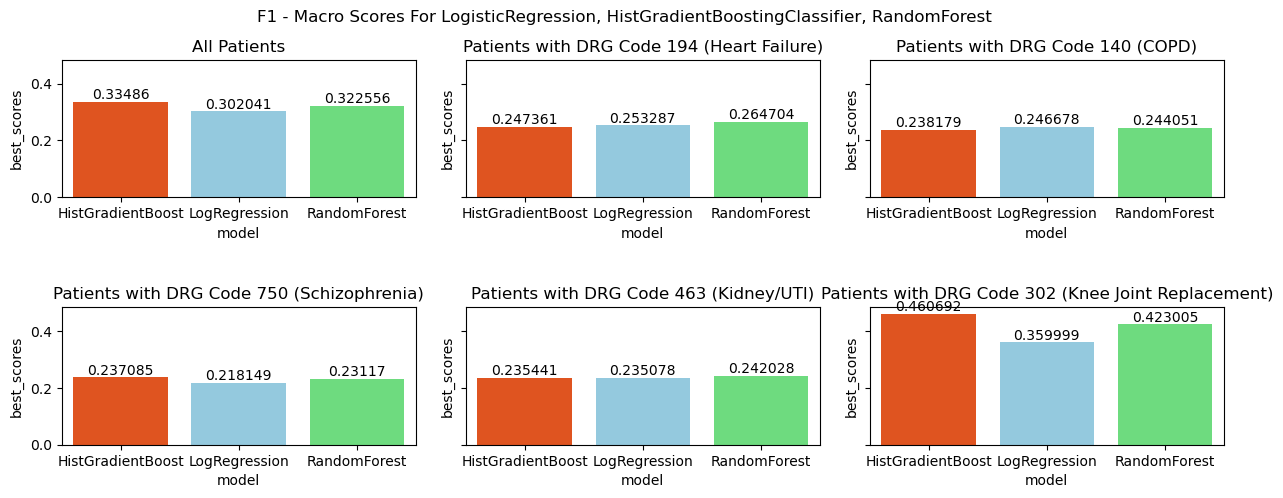

In [75]:
#Create visualization for each subpopulation for each model
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=True)

fig.subplots_adjust(hspace=0.8, wspace=0.140)


fig.suptitle('F1 - Macro Scores For LogisticRegression, HistGradientBoostingClassifier, RandomForest')

all_patients = randomized_search_results[randomized_search_results['subpopulation'] == 'all']
heart_patients = randomized_search_results[randomized_search_results['subpopulation'] == 194.0]
copd_patients = randomized_search_results[randomized_search_results['subpopulation'] == 140.0]
schizophrenia_patients = randomized_search_results[randomized_search_results['subpopulation'] == 750.0]
kidney_patients = randomized_search_results[randomized_search_results['subpopulation'] == 463.0]
knee_rep_patients = randomized_search_results[randomized_search_results['subpopulation'] == 302.0]

sns.barplot(ax=axes[0, 0], x=all_patients['model'], y=all_patients['best_scores'], palette=['orangered', 'skyblue','#5CED73'])
axes[0, 0].set_title('All Patients')
axes[0, 0].bar_label(axes[0,0].containers[0])

sns.barplot(ax=axes[0, 1], x=heart_patients['model'], y=heart_patients['best_scores'], palette=['orangered', 'skyblue','#5CED73'])
axes[0, 1].set_title('Patients with DRG Code 194 (Heart Failure)')
axes[0, 1].bar_label(axes[0,1].containers[0])

sns.barplot(ax=axes[0, 2], x=copd_patients['model'], y=copd_patients['best_scores'], palette=['orangered', 'skyblue','#5CED73'])
axes[0, 2].set_title('Patients with DRG Code 140 (COPD)')
axes[0, 2].bar_label(axes[0,2].containers[0])

sns.barplot(ax=axes[1, 0], x=schizophrenia_patients['model'], y=schizophrenia_patients['best_scores'], palette=['orangered', 'skyblue','#5CED73'])
axes[1, 0].set_title('Patients with DRG Code 750 (Schizophrenia)')
axes[1, 0].bar_label(axes[1, 0].containers[0])

sns.barplot(ax=axes[1, 1], x=kidney_patients['model'], y=kidney_patients['best_scores'], palette=['orangered', 'skyblue','#5CED73'])
axes[1, 1].set_title('Patients with DRG Code 463 (Kidney/UTI)')
axes[1, 1].bar_label(axes[1,1].containers[0])

sns.barplot(ax=axes[1, 2], x=knee_rep_patients['model'], y=knee_rep_patients['best_scores'], palette=['orangered', 'skyblue','#5CED73'])
axes[1, 2].set_title('Patients with DRG Code 302 (Knee Joint Replacement)')
axes[1, 2].bar_label(axes[1, 2].containers[0])
plt.savefig('data/visualizations/Cost_PerfomanceAcrossModels.png')

It looks like for most models, the HistGradientBoostingClassifier does almost the same as the Random Forest Classifier but does slightly better than the LogisticRegression model in for all subpopulations and all patients. Let's train each subpopulation on their best parameters for HistGradientBoostingClassifier model.

In [67]:
final_model_scores = []

for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    subpop_df = load_data(drg)
    subpop_df['Total Costs Bin'] = pd.cut(x = subpop_df['Total Costs'], bins = bins, 
                                          labels = labels, include_lowest = True)      
    X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(subpop_df)

    best_params = scores_gb_df.loc[(scores_gb_df['model']=='HistGradientBoost') & 
                                   (scores_gb_df['subpopulation']==drg)]['best_params'].values[0]
    model_scores = get_cost_model_scores(best_params, X_train, X_test, y_train, y_test)
    final_model_scores.append({
        'Population': drg,
        'Accuracy Score': model_scores[0],
        'F1_score_macro': model_scores[1],
        'F1_score_weighted': model_scores[2],
        'Model':'HistGradientBoost'
    })

final_results_df = pd.DataFrame(final_model_scores)

all


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


       Hospital Service Area Hospital County  Permanent Facility Id  \
0              Hudson Valley     Westchester                 1061.0   
1              Hudson Valley     Westchester                 1061.0   
2              Hudson Valley     Westchester                 1072.0   
3              Hudson Valley        Sullivan                  971.0   
4              Hudson Valley        Sullivan                  971.0   
...                      ...             ...                    ...   
420987         New York City          Queens                 1629.0   
420988         New York City          Queens                 1629.0   
420989          Finger Lakes         Ontario                  676.0   
420990         New York City           Bronx                 3058.0   
420991         New York City           Bronx                 1169.0   

          Age Group  Gender                    Race          Ethnicity  \
0          30 to 49    Male                   White  Not Span/Hispanic   

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


Training model
Getting model scores
194.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:8: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_HeartFailure.csv')


       Hospital Service Area Hospital County  Permanent Facility Id  \
0              Hudson Valley     Westchester                 1061.0   
1              Hudson Valley     Westchester                 1072.0   
2              Hudson Valley        Sullivan                  971.0   
3              Hudson Valley        Sullivan                  971.0   
4              Hudson Valley        Sullivan                  971.0   
...                      ...             ...                    ...   
126582                   NaN             NaN                10216.0   
126583                   NaN             NaN                10216.0   
126584         New York City           Bronx                 1169.0   
126585         New York City          Queens                 1629.0   
126586         New York City           Bronx                 3058.0   

          Age Group  Gender                    Race          Ethnicity  \
0          50 to 69    Male                   White   Spanish/Hispanic   

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:8: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_HeartFailure.csv')


Training model
Getting model scores
140.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:11: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_ChronicObstructivePulmonaryDisease.csv')


      Hospital Service Area Hospital County  Permanent Facility Id  \
0             New York City           Kings                 1324.0   
1             New York City           Kings                 1324.0   
2             New York City       Manhattan                 1439.0   
3             New York City       Manhattan                 1456.0   
4             New York City       Manhattan                 1456.0   
...                     ...             ...                    ...   
80018                   NaN             NaN                10216.0   
80019                   NaN             NaN                10216.0   
80020       Capital/Adirond         Clinton                  135.0   
80021         New York City          Queens                 1629.0   
80022         New York City           Bronx                 1169.0   

         Age Group  Gender                    Race          Ethnicity  \
0         50 to 69    Male                   White  Not Span/Hispanic   
1      70 or 

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:11: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_ChronicObstructivePulmonaryDisease.csv')


Training model


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(


Getting model scores
750.0
      Hospital Service Area Hospital County  Permanent Facility Id Age Group  \
0             Hudson Valley     Westchester                 1061.0  30 to 49   
1             Hudson Valley        Sullivan                  971.0  30 to 49   
2             Hudson Valley        Sullivan                  971.0  18 to 29   
3             Hudson Valley        Sullivan                  971.0  30 to 49   
4             Hudson Valley        Sullivan                  971.0  30 to 49   
...                     ...             ...                    ...       ...   
70869         New York City          Queens                 1629.0  18 to 29   
70870         New York City          Queens                 1629.0  30 to 49   
70871         New York City       Manhattan                 1466.0  18 to 29   
70872         New York City          Queens                 1630.0  18 to 29   
70873         New York City          Queens                 1629.0  50 to 69   

       Gende

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:14: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_Schizophrenia.csv')
/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:14: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_Schizophrenia.csv')


Training model
Getting model scores
463.0
      Hospital Service Area Hospital County  Permanent Facility Id  \
0             Hudson Valley        Sullivan                  971.0   
1             Hudson Valley        Sullivan                  971.0   
2             New York City           Kings                 1324.0   
3             New York City           Kings                 1324.0   
4             New York City       Manhattan                 1439.0   
...                     ...             ...                    ...   
60964         New York City           Kings                 1301.0   
60965         New York City           Kings                 1294.0   
60966         New York City           Kings                 1294.0   
60967         New York City          Queens                 1629.0   
60968          Finger Lakes         Ontario                  676.0   

         Age Group  Gender                    Race          Ethnicity  \
0      70 or Older  Female                  

/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(


Getting model scores
302.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:20: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_KneeJointReplacement.csv')


      Hospital Service Area Hospital County  Permanent Facility Id  \
0             New York City       Manhattan                 1456.0   
1             New York City       Manhattan                 1456.0   
2             New York City       Manhattan                 1466.0   
3             New York City       Manhattan                 1466.0   
4             New York City       Manhattan                 1466.0   
...                     ...             ...                    ...   
82534       Capital/Adirond         Clinton                  135.0   
82535       Capital/Adirond         Clinton                  135.0   
82536       Capital/Adirond         Clinton                  135.0   
82537       Capital/Adirond         Clinton                  135.0   
82538         New York City           Bronx                 1168.0   

         Age Group  Gender                    Race          Ethnicity  \
0         50 to 69  Female              Other Race  Not Span/Hispanic   
1      70 or 

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:20: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_KneeJointReplacement.csv')


Training model
Getting model scores


In [47]:
final_results_df

,Population,Accuracy Score,F1_score_macro,F1_score_weighted,Model
0,all,0.436178,0.370458,0.416555,HistGradientBoost
1,194.0,0.387761,0.268993,0.340764,HistGradientBoost
2,140.0,0.427084,0.231876,0.379332,HistGradientBoost
3,750.0,0.302229,0.253698,0.276858,HistGradientBoost
4,463.0,0.465967,0.227093,0.410986,HistGradientBoost
5,302.0,0.604798,0.470074,0.593869,HistGradientBoost


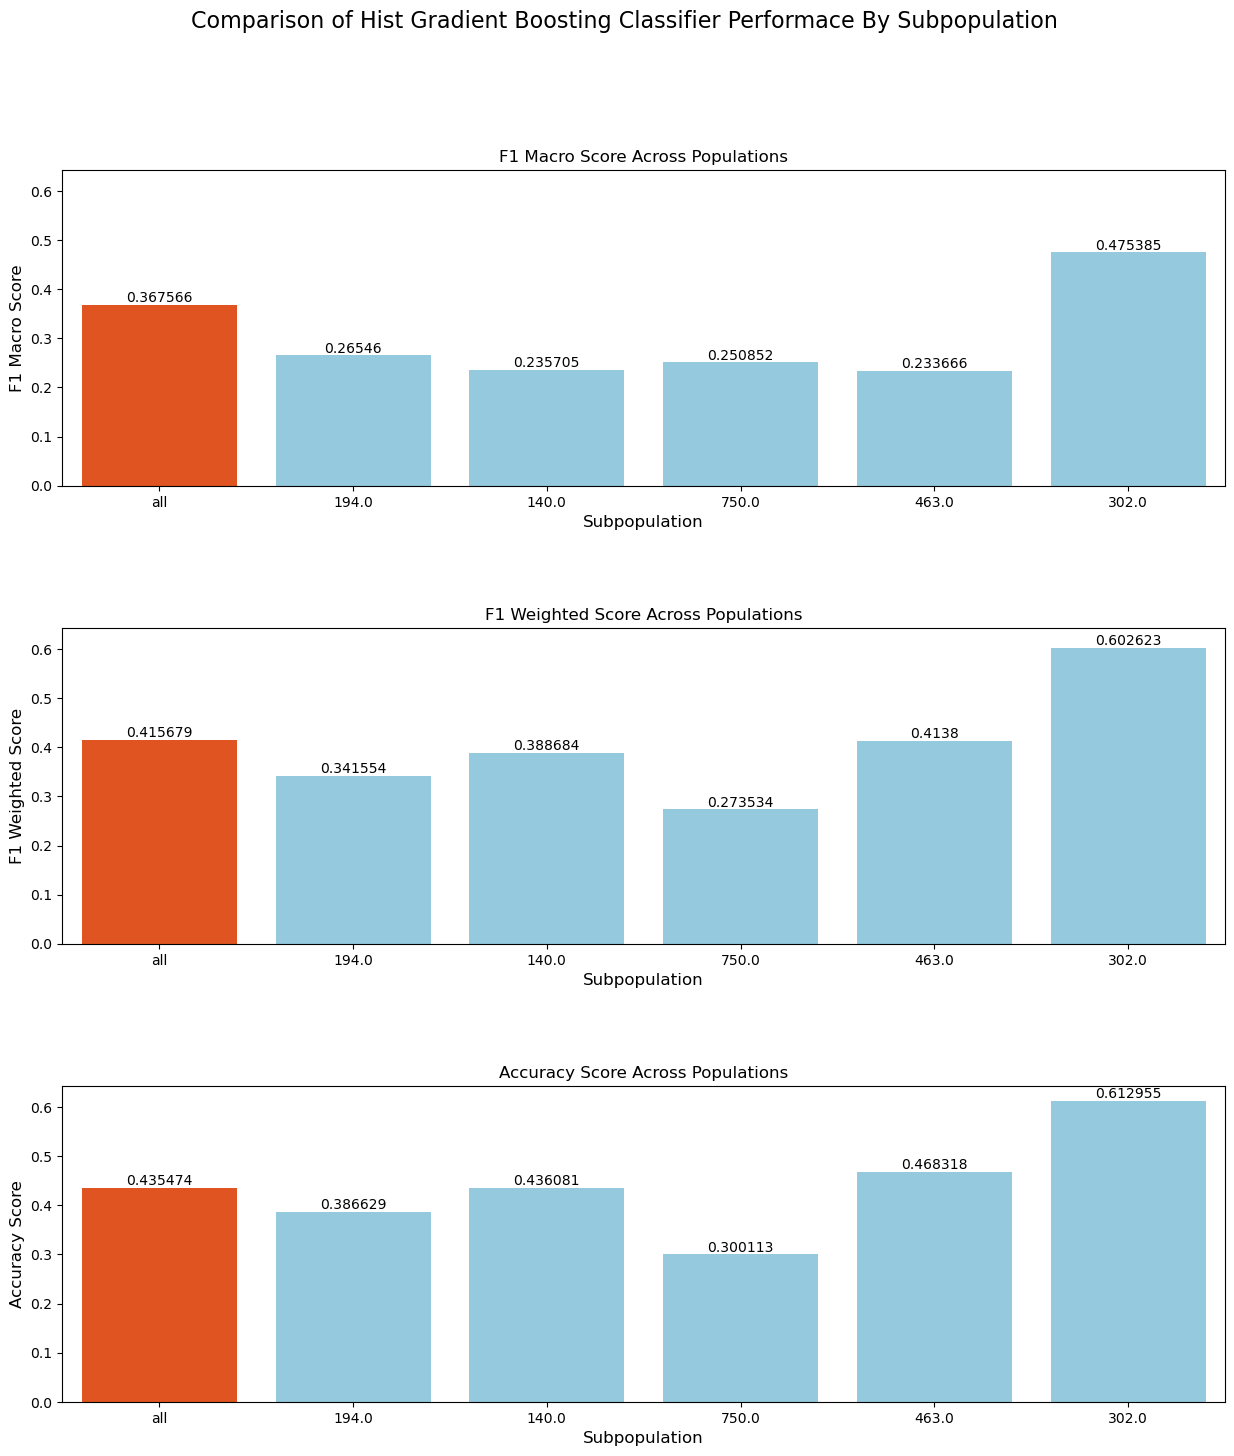

In [74]:
#Visualize the results
#Build visualization comparing random forest model performance of all populations
colors = ['orangered' if (x == 'all') else 'skyblue' for x in final_results_df['Population'].values]

fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharey=True)
fig.subplots_adjust(hspace=0.45, wspace=0.25)
fig.suptitle('Comparison of Hist Gradient Boosting Classifier Performace By Subpopulation', fontsize=16)

sns.barplot(ax=axes[0], x=final_results_df['Population'], y=final_results_df['F1_score_macro'], palette=colors)
axes[0].set_xlabel('Subpopulation', fontsize=12)
axes[0].set_ylabel('F1 Macro Score', fontsize=12)
axes[0].bar_label(axes[0].containers[0])
axes[0].set_title('F1 Macro Score Across Populations')

sns.barplot(ax=axes[1], x=final_results_df['Population'], y=final_results_df['F1_score_weighted'], palette=colors)
axes[1].set_xlabel('Subpopulation', fontsize=12)
axes[1].set_ylabel('F1 Weighted Score', fontsize=12)
axes[1].bar_label(axes[1].containers[0])
axes[1].set_title('F1 Weighted Score Across Populations')

sns.barplot(ax=axes[2], x=final_results_df['Population'], y=final_results_df['Accuracy Score'], palette=colors)
axes[2].set_xlabel('Subpopulation', fontsize=12)
axes[2].set_ylabel('Accuracy Score', fontsize=12)
axes[2].bar_label(axes[2].containers[0])
axes[2].set_title('Accuracy Score Across Populations')

plt.savefig('data/visualizations/Cost_Performance_HistGBC.png')

From the visualization above, it can be seen that for F1 macro scores the model built on all conditions of interest outperforms models trained only on patients with a specific DRG code with the exception of Knee replacement patients.
<br /><br />
Let's also compare performance with a dummy classifier which predicts the majority class every time and a dummy classifier which selects a class at random.

In [49]:
#Get dummy model performance on all the population datasets
final_model_scores = []

#all population
for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    print(drg)
    subpop_df = load_data(drg)
    subpop_df['Total Costs Bin'] = pd.cut(x = subpop_df['Total Costs'], bins = bins, 
                                          labels = labels, include_lowest = True) 
    X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(subpop_df)
    
    most_freq_dummy_scores = get_dummy_scores("most_frequent", X_train, X_test, y_train, y_test)

    final_model_scores.append({
        'Population': drg,
        'Model': 'DummyClassifier - Most Frequent',
        'Accuracy Score': most_freq_dummy_scores[0],
        'F1_score_macro': most_freq_dummy_scores[1],
        'F1_score_weighted': most_freq_dummy_scores[2]
    })

    random_dummy_scores = get_dummy_scores("uniform", X_train, X_test, y_train, y_test)

    final_model_scores.append({
        'Population': drg,
        'Model': 'DummyClassifier - Random',
        'Accuracy Score': random_dummy_scores[0],
        'F1_score_macro': random_dummy_scores[1],
        'F1_score_weighted': random_dummy_scores[2]
    })

all
all


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


       Hospital Service Area Hospital County  Permanent Facility Id  \
0              Hudson Valley     Westchester                 1061.0   
1              Hudson Valley     Westchester                 1061.0   
2              Hudson Valley     Westchester                 1072.0   
3              Hudson Valley        Sullivan                  971.0   
4              Hudson Valley        Sullivan                  971.0   
...                      ...             ...                    ...   
420987         New York City          Queens                 1629.0   
420988         New York City          Queens                 1629.0   
420989          Finger Lakes         Ontario                  676.0   
420990         New York City           Bronx                 3058.0   
420991         New York City           Bronx                 1169.0   

          Age Group  Gender                    Race          Ethnicity  \
0          30 to 49    Male                   White  Not Span/Hispanic   

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


194.0
194.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:8: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_HeartFailure.csv')


       Hospital Service Area Hospital County  Permanent Facility Id  \
0              Hudson Valley     Westchester                 1061.0   
1              Hudson Valley     Westchester                 1072.0   
2              Hudson Valley        Sullivan                  971.0   
3              Hudson Valley        Sullivan                  971.0   
4              Hudson Valley        Sullivan                  971.0   
...                      ...             ...                    ...   
126582                   NaN             NaN                10216.0   
126583                   NaN             NaN                10216.0   
126584         New York City           Bronx                 1169.0   
126585         New York City          Queens                 1629.0   
126586         New York City           Bronx                 3058.0   

          Age Group  Gender                    Race          Ethnicity  \
0          50 to 69    Male                   White   Spanish/Hispanic   

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:8: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_HeartFailure.csv')


140.0
140.0


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:11: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_ChronicObstructivePulmonaryDisease.csv')


      Hospital Service Area Hospital County  Permanent Facility Id  \
0             New York City           Kings                 1324.0   
1             New York City           Kings                 1324.0   
2             New York City       Manhattan                 1439.0   
3             New York City       Manhattan                 1456.0   
4             New York City       Manhattan                 1456.0   
...                     ...             ...                    ...   
80018                   NaN             NaN                10216.0   
80019                   NaN             NaN                10216.0   
80020       Capital/Adirond         Clinton                  135.0   
80021         New York City          Queens                 1629.0   
80022         New York City           Bronx                 1169.0   

         Age Group  Gender                    Race          Ethnicity  \
0         50 to 69    Male                   White  Not Span/Hispanic   
1      70 or 

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:11: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_ChronicObstructivePulmonaryDisease.csv')


750.0
750.0
      Hospital Service Area Hospital County  Permanent Facility Id Age Group  \
0             Hudson Valley     Westchester                 1061.0  30 to 49   
1             Hudson Valley        Sullivan                  971.0  30 to 49   
2             Hudson Valley        Sullivan                  971.0  18 to 29   
3             Hudson Valley        Sullivan                  971.0  30 to 49   
4             Hudson Valley        Sullivan                  971.0  30 to 49   
...                     ...             ...                    ...       ...   
70869         New York City          Queens                 1629.0  18 to 29   
70870         New York City          Queens                 1629.0  30 to 49   
70871         New York City       Manhattan                 1466.0  18 to 29   
70872         New York City          Queens                 1630.0  18 to 29   
70873         New York City          Queens                 1629.0  50 to 69   

       Gender              

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:14: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_Schizophrenia.csv')
/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:14: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_Schizophrenia.csv')


463.0
463.0
      Hospital Service Area Hospital County  Permanent Facility Id  \
0             Hudson Valley        Sullivan                  971.0   
1             Hudson Valley        Sullivan                  971.0   
2             New York City           Kings                 1324.0   
3             New York City           Kings                 1324.0   
4             New York City       Manhattan                 1439.0   
...                     ...             ...                    ...   
60964         New York City           Kings                 1301.0   
60965         New York City           Kings                 1294.0   
60966         New York City           Kings                 1294.0   
60967         New York City          Queens                 1629.0   
60968          Finger Lakes         Ontario                  676.0   

         Age Group  Gender                    Race          Ethnicity  \
0      70 or Older  Female                   White  Not Span/Hispanic   
1

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:20: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_KneeJointReplacement.csv')


      Hospital Service Area Hospital County  Permanent Facility Id  \
0             New York City       Manhattan                 1456.0   
1             New York City       Manhattan                 1456.0   
2             New York City       Manhattan                 1466.0   
3             New York City       Manhattan                 1466.0   
4             New York City       Manhattan                 1466.0   
...                     ...             ...                    ...   
82534       Capital/Adirond         Clinton                  135.0   
82535       Capital/Adirond         Clinton                  135.0   
82536       Capital/Adirond         Clinton                  135.0   
82537       Capital/Adirond         Clinton                  135.0   
82538         New York City           Bronx                 1168.0   

         Age Group  Gender                    Race          Ethnicity  \
0         50 to 69  Female              Other Race  Not Span/Hispanic   
1      70 or 

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:20: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/HID_cleaned_KneeJointReplacement.csv')


In [51]:
final_scores_df = pd.DataFrame(final_model_scores)
final_results_with_dummy_df = pd.concat([final_results_df, final_scores_df], ignore_index=True)
final_results_with_dummy_df

,Population,Accuracy Score,F1_score_macro,F1_score_weighted,Model
0,all,0.436178,0.370458,0.416555,HistGradientBoost
1,194.0,0.387761,0.268993,0.340764,HistGradientBoost
2,140.0,0.427084,0.231876,0.379332,HistGradientBoost
3,750.0,0.302229,0.253698,0.276858,HistGradientBoost
4,463.0,0.465967,0.227093,0.410986,HistGradientBoost
5,302.0,0.604798,0.470074,0.593869,HistGradientBoost
6,all,0.277687,0.062096,0.120702,DummyClassifier - Most Frequent
7,all,0.141571,0.130198,0.152984,DummyClassifier - Random
8,194.0,0.329147,0.070754,0.163018,DummyClassifier - Most Frequent
9,194.0,0.140559,0.126620,0.154366,DummyClassifier - Random


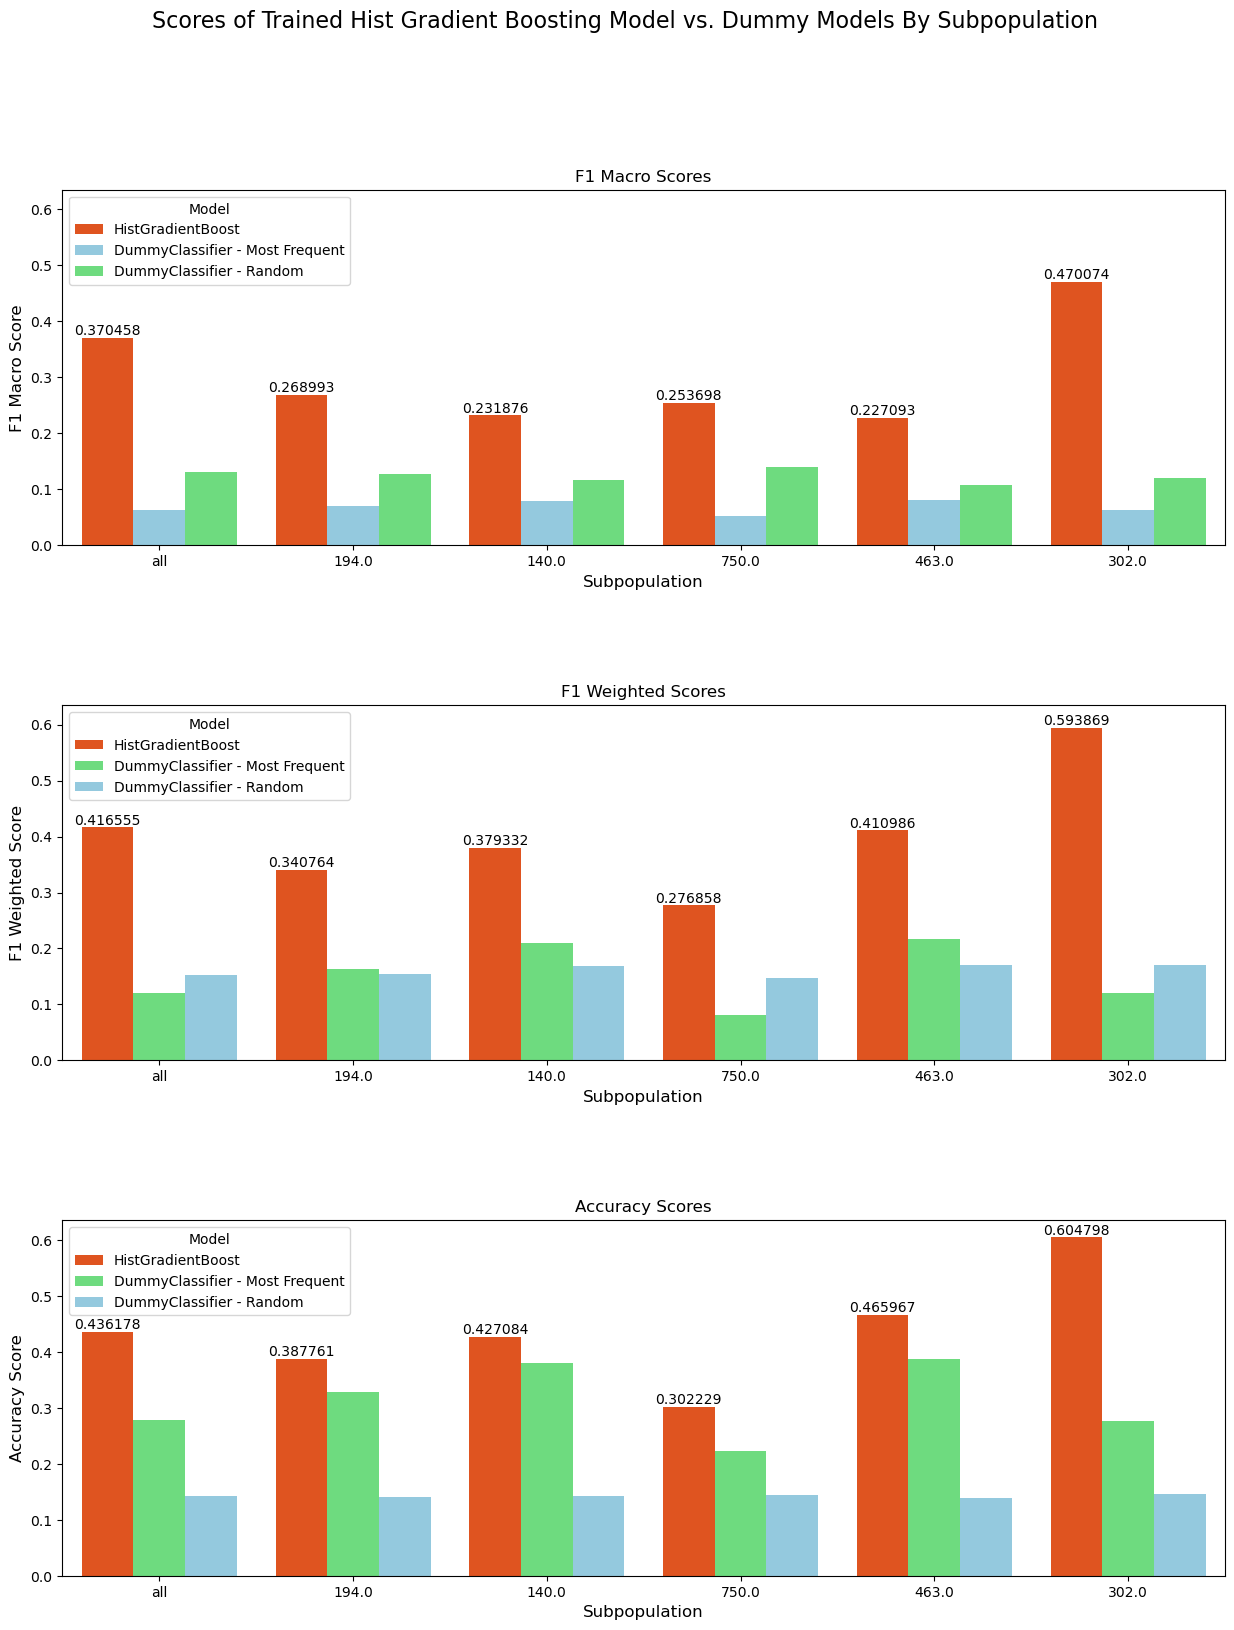

In [73]:
#Plot dummy classifiers vs rf model performance for each population
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharey=True)
fig.subplots_adjust(hspace=0.45, wspace=0.25)
fig.suptitle('Scores of Trained Hist Gradient Boosting Model vs. Dummy Models By Subpopulation', fontsize=16)

sns.barplot(ax=axes[0], data=final_results_with_dummy_df, x="Population", y="F1_score_macro", 
            hue="Model",palette= ['orangered','skyblue', '#5CED73'])
axes[0].set_xlabel('Subpopulation', fontsize=12)
axes[0].set_ylabel('F1 Macro Score', fontsize=12)
axes[0].bar_label(axes[0].containers[0])
axes[0].set_title('F1 Macro Scores')

sns.barplot(ax=axes[1], data=final_results_with_dummy_df, x="Population", y="F1_score_weighted", 
            hue="Model",palette= ['orangered','#5CED73', 'skyblue', '#5CED73'])
axes[1].set_xlabel('Subpopulation', fontsize=12)
axes[1].set_ylabel('F1 Weighted Score', fontsize=12)
axes[1].bar_label(axes[1].containers[0])
axes[1].set_title('F1 Weighted Scores')

sns.barplot(ax=axes[2], data=final_results_with_dummy_df, x="Population", y="Accuracy Score", 
            hue="Model",palette= ['orangered', '#5CED73','skyblue', '#5CED73'])
axes[2].set_xlabel('Subpopulation', fontsize=12)
axes[2].set_ylabel('Accuracy Score', fontsize=12)
axes[2].bar_label(axes[2].containers[0])
axes[2].set_title('Accuracy Scores')

plt.savefig('data/visualizations/Cost_HGB_vs_Dummy.png')

The models do outperform the dummy models, especially when comparing the F1 Macro score. However, overall we can see that the F1 macro scores are still fairly low for the trained models.

<br /><br />
As a next step, we will be performing Oversampling, because of the performance time of this, it has been commented out.

In [72]:
from imblearn.over_sampling import SMOTE

In [56]:
## uncomment to run this cell

# oversample_scores = []

# oversample = SMOTE()

# best_params = scores_gb_df.loc[(scores_gb_df['model']=='HistGradientBoost') & (scores_gb_df['subpopulation']=='all')]['best_params'].values[0]

# subpop_df = load_data('all')
# subpop_df['Total Costs Bin'] = pd.cut(x = subpop_df['Total Costs'], bins = bins, 
#                                           labels = labels, include_lowest = True)

# X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(subpop_df)

# X_train_resample, y_train_resample = oversample.fit_resample(X_train, y_train)

# oversampled_model = train_cost_model(best_params, X_train_resample, y_train_resample)

# oversample_scores.append({
#     'Population': 'all',
#     'Model': 'Upsampled',
#     'Accuracy Score': model_scores[0],
#     'F1_score_macro': model_scores[1],
#     'F1_score_weighted': model_scores[2]
# })

# final_results_df = final_results_df.append(oversample_scores)
# final_results_df


In [ ]:

# #Plot oversampling
# fig, axes = plt.subplots(1, 3, figsize=(15, 18), sharey=True)
# fig.subplots_adjust(hspace=0.45, wspace=0.25)
# fig.suptitle('Scores of Trained Hist Gradient Boosting Model vs. Dummy Models By Subpopulation', fontsize=16)

# final_results_upsampled = final_results_df[final_results_df['Population'] == 'all']
# sns.barplot(ax=axes[0], data=final_results_df, x="Model", y="F1_score_macro", palette= ['orangered', 'skyblue'], ci=None)
# axes[0].set_xlabel('Model', fontsize=12)
# axes[0].set_ylabel('F1 Macro Score', fontsize=12)
# axes[0].bar_label(axes[0].containers[0], fmt='%.3f', padding=2, fontsize=12)
# axes[0].set_title('F1 Macro Scores')
# axes[0].tick_params(axis='x', rotation=90)

# sns.barplot(ax=axes[1], data=final_results_df, x="Model", y="F1_score_weighted", palette= ['orangered', 'skyblue'], ci=None)
# axes[1].set_xlabel('Model', fontsize=12)
# axes[1].set_ylabel('F1 Weighted Score', fontsize=12)
# axes[1].bar_label(axes[1].containers[0], fmt='%.3f', padding=2, fontsize=12)
# axes[1].set_title('F1 Weighted Scores')
# axes[1].tick_params(axis='x', rotation=90)

# sns.barplot(ax=axes[2], data=final_results_df, x="Model", y="Accuracy Score", palette= ['orangered', 'skyblue'], ci=None)
# axes[2].set_xlabel('Model', fontsize=12)
# axes[2].set_ylabel('Accuracy Score', fontsize=12)
# axes[2].bar_label(axes[2].containers[0], fmt='%.3f', padding=2, fontsize=12)
# axes[2].set_title('Accuracy Scores')
# axes[2].tick_params(axis='x', rotation=90)

# plt.savefig('data/visualizations/Cost_upsampled_vs_original.png')